In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [40]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

In [41]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [42]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

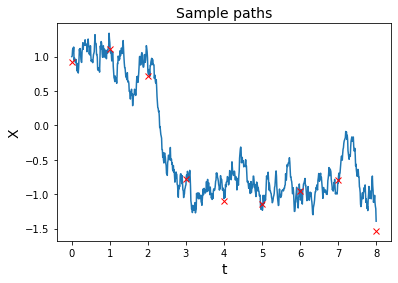

In [43]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + \sigma dW_t$$

$$\log\exp{\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}}^{t_{1}}\frac{4Z_{t}(1-Z^{2}_{t}) + r(Z_{t}-m(t))-m'(t)}{\sigma^{2}}dZ_{t} - \frac{1}{2}\int_{t_{0}}^{t_{1}}\frac{16Z^{2}_{t}(1-Z^{2}_{t})^{2} - (-r(Z_{t} - m(t)) + m'(t))^{2}}{\sigma^{2}}dt$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

Please note that $E(Z_t) = m(t)$. Here we consider a variational process with a $\textbf{linear mean function}$, i.e. $\beta = 1$, which results in $m(t) = \alpha t + m_{0}$. Our variational parameters, thus, include $r, \alpha, m_{0}$

In [68]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
            
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        
#         func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
#                 - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
#                 + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
#                                                                                 alpha * beta * B(s, beta-1))
        def integral(s, z):
            return (16 * z * z * (1 - z * z) ** 2) - ((-r * (z - m(s)) + m_(s)) ** 2)
    
        num = integral(t, self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1) / (sigma * sigma)
#         return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = alpha.shape[0]
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)

        t0 = t[:, 0]
        t1 = t[:, -1]
        
                
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        def B(s, beta):
            return (s+1) ** beta
        
#         def A(s, u):
#             return (-1 * (u ** 4) + 0.5 * (4+r) * (u ** 2) - u * r * (alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
        def A(s, u):
            return (-1 * u ** 4 + 0.5 * (4 + r) * u * u - (r * m(s) + m_(s)) * u) / (sigma * sigma)
                
        def integral_01(t0, t1):
            return r * alpha * B(t1, beta) + alpha * beta * B(t1, beta-1) - r * alpha * B(t0, beta) - alpha * beta * B(t0, beta-1)
        
        return A(t1, z1) - A(t0, z0) + integral_01(t0, t1) / (sigma * sigma) - 0.5 * (4 + r) * (t1 - t0) + 6 * torch.trapezoid(self.ou.trj ** 2, x=t)
#         return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [66]:
import tqdm as tq

In [128]:
D = 50
S = 100
learning_rate = 0.00005
lr = learning_rate
IT = 1000
dN = 200
z0 = obs[0]

# Linear mean function
beta_ = torch.tensor([1.])
beta_D = beta_.repeat(D, 1)
beta_S = beta_.repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1) + 4.
    if t > 1:
        r_ = torch.tensor([4.])
    m0_ = torch.randn(1) + obs[t].clone().detach()
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * gradient['m0'])
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_S, sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_82105/906047145.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma = torch.tensor(ou.sigma)


alpha =  [-0.00267856] m0 =  [1.1252412] r =  [4.340685]
(Neg) elbo =  10.849421918674434
alpha =  [-0.0503956] m0 =  [1.04590432] r =  [4.346034]
(Neg) elbo =  5.990283015367581
alpha =  [-0.06049883] m0 =  [1.01355383] r =  [4.3514037]
(Neg) elbo =  6.242545793217165
alpha =  [-0.06032181] m0 =  [0.99281617] r =  [4.355549]
(Neg) elbo =  5.097707206389048
alpha =  [-0.05012908] m0 =  [0.98365808] r =  [4.360418]
(Neg) elbo =  6.3669885113925835
alpha =  [-0.04205074] m0 =  [0.97356038] r =  [4.36536]
(Neg) elbo =  6.162662280580009
alpha =  [-0.03518747] m0 =  [0.96361866] r =  [4.3695345]
(Neg) elbo =  6.239309560660196
alpha =  [-0.02046609] m0 =  [0.96226455] r =  [4.3735547]
(Neg) elbo =  3.7086163355785153
alpha =  [-0.01485895] m0 =  [0.95002501] r =  [4.3780375]
(Neg) elbo =  5.860358350597571
alpha =  [0.00088058] m0 =  [0.95184075] r =  [4.3821726]
(Neg) elbo =  6.047835440946788
alpha =  [0.00107554] m0 =  [0.93440038] r =  [4.3875327]
(Neg) elbo =  3.6601888603644044
alpha

 12%|█████▋                                       | 1/8 [00:46<05:26, 46.66s/it]

alpha =  [0.0018195] m0 =  [0.14457213] r =  [4.9184585]
(Neg) elbo =  22.28508196311971
alpha =  [0.116926] m0 =  [0.26302741] r =  [4.9182143]
(Neg) elbo =  9.45732861437227
alpha =  [0.18345858] m0 =  [0.33171547] r =  [4.9182835]
(Neg) elbo =  8.30426911333904
alpha =  [0.22450157] m0 =  [0.37287522] r =  [4.919104]
(Neg) elbo =  4.568093347698928
alpha =  [0.24991938] m0 =  [0.40051888] r =  [4.9196777]
(Neg) elbo =  3.5550633971081864
alpha =  [0.26177734] m0 =  [0.41363913] r =  [4.920707]
(Neg) elbo =  4.171860423498534
alpha =  [0.26909488] m0 =  [0.42213807] r =  [4.92201]
(Neg) elbo =  3.961783599906945
alpha =  [0.27065596] m0 =  [0.42474065] r =  [4.923122]
(Neg) elbo =  2.99355194932412
alpha =  [0.27065182] m0 =  [0.4246012] r =  [4.924474]
(Neg) elbo =  3.8988713376416926
alpha =  [0.27215755] m0 =  [0.4273959] r =  [4.9254527]
(Neg) elbo =  3.213957991653453
alpha =  [0.27193758] m0 =  [0.42795774] r =  [4.9266863]
(Neg) elbo =  3.535706483223023
alpha =  [0.27194315] 

 25%|███████████▎                                 | 2/8 [01:33<04:41, 46.91s/it]

alpha =  [-0.03032995] m0 =  [1.2781037] r =  [3.9998057]
(Neg) elbo =  236.62932972340593
alpha =  [-0.46606117] m0 =  [0.8441478] r =  [4.0039086]
(Neg) elbo =  75.19614021285547
alpha =  [-0.6839917] m0 =  [0.63004268] r =  [4.00453]
(Neg) elbo =  37.20683846960048
alpha =  [-0.8222472] m0 =  [0.49574053] r =  [4.0070434]
(Neg) elbo =  19.613177682972605
alpha =  [-0.9063735] m0 =  [0.41750861] r =  [4.0090594]
(Neg) elbo =  15.127706839037616
alpha =  [-0.95745486] m0 =  [0.36935581] r =  [4.010218]
(Neg) elbo =  14.945150073435798
alpha =  [-0.9896336] m0 =  [0.34038135] r =  [4.012485]
(Neg) elbo =  15.02241178126772
alpha =  [-1.0070802] m0 =  [0.32864842] r =  [4.01394]
(Neg) elbo =  14.139877857996183
alpha =  [-1.0149572] m0 =  [0.32842437] r =  [4.0155687]
(Neg) elbo =  14.410600382041995
alpha =  [-1.0241284] m0 =  [0.32381386] r =  [4.016809]
(Neg) elbo =  14.945675777694403
alpha =  [-1.0319415] m0 =  [0.3224806] r =  [4.0185623]
(Neg) elbo =  14.632952624036081
alpha =  

 38%|████████████████▉                            | 3/8 [02:20<03:54, 46.97s/it]

alpha =  [0.00254165] m0 =  [1.01912572] r =  [3.9993863]
(Neg) elbo =  224.73449932998736
alpha =  [-0.3760247] m0 =  [0.63783812] r =  [3.9820378]
(Neg) elbo =  99.00248899197481
alpha =  [-0.6309357] m0 =  [0.37951052] r =  [3.9746068]
(Neg) elbo =  51.423973407037195
alpha =  [-0.80468416] m0 =  [0.20180423] r =  [3.9736662]
(Neg) elbo =  23.49467382062945
alpha =  [-0.89824957] m0 =  [0.10559279] r =  [3.9739835]
(Neg) elbo =  18.541427926117358
alpha =  [-0.94494975] m0 =  [0.06311406] r =  [3.9767265]
(Neg) elbo =  17.314632463726692
alpha =  [-0.9690841] m0 =  [0.041272] r =  [3.9802244]
(Neg) elbo =  18.10107486806717
alpha =  [-0.9802236] m0 =  [0.03461977] r =  [3.983774]
(Neg) elbo =  16.477312908435966
alpha =  [-0.9934122] m0 =  [0.02270006] r =  [3.9860563]
(Neg) elbo =  15.156893137287605
alpha =  [-0.9938511] m0 =  [0.02624412] r =  [3.989243]
(Neg) elbo =  16.148805605771877
alpha =  [-1.0042504] m0 =  [0.01654469] r =  [3.9924057]
(Neg) elbo =  15.634713634586683
alp

 50%|██████████████████████▌                      | 4/8 [03:07<03:07, 46.90s/it]

alpha =  [0.20627663] m0 =  [-2.36514504] r =  [3.9747825]
(Neg) elbo =  767.7624272625778
alpha =  [0.71129227] m0 =  [-1.65341645] r =  [3.9551966]
(Neg) elbo =  9.191462817225972
alpha =  [0.71825486] m0 =  [-1.59236661] r =  [3.957294]
(Neg) elbo =  5.638761692464935
alpha =  [0.70999205] m0 =  [-1.54871262] r =  [3.9605951]
(Neg) elbo =  5.168752766371957
alpha =  [0.6947742] m0 =  [-1.52131574] r =  [3.963423]
(Neg) elbo =  1.6334128424287824
alpha =  [0.66962343] m0 =  [-1.50395924] r =  [3.9673705]
(Neg) elbo =  2.7618391465587506
alpha =  [0.64056087] m0 =  [-1.49560024] r =  [3.9716237]
(Neg) elbo =  3.8606354658504634
alpha =  [0.6215988] m0 =  [-1.46890831] r =  [3.9762447]
(Neg) elbo =  7.591062931680231
alpha =  [0.5999904] m0 =  [-1.44816418] r =  [3.9808896]
(Neg) elbo =  2.329843316115012
alpha =  [0.57831115] m0 =  [-1.4321356] r =  [3.9849086]
(Neg) elbo =  0.9540281365201762
alpha =  [0.5575765] m0 =  [-1.41558116] r =  [3.9902766]
(Neg) elbo =  2.4976400850279883
a

 62%|████████████████████████████▏                | 5/8 [03:54<02:20, 46.86s/it]

alpha =  [0.04302029] m0 =  [-1.75237584] r =  [4.001342]
(Neg) elbo =  158.85824761070546
alpha =  [0.35352647] m0 =  [-1.35308379] r =  [4.004347]
(Neg) elbo =  7.326408561229645
alpha =  [0.39875105] m0 =  [-1.27832004] r =  [4.0083675]
(Neg) elbo =  -1.2691765373736217
alpha =  [0.40560687] m0 =  [-1.24653166] r =  [4.012677]
(Neg) elbo =  3.912776584422686
alpha =  [0.39930514] m0 =  [-1.23432323] r =  [4.0163016]
(Neg) elbo =  1.0813242506550993
alpha =  [0.39494714] m0 =  [-1.21733755] r =  [4.020895]
(Neg) elbo =  -1.109184991635789
alpha =  [0.38247547] m0 =  [-1.21367783] r =  [4.023954]
(Neg) elbo =  0.20218160069287083
alpha =  [0.37527055] m0 =  [-1.20448759] r =  [4.0279922]
(Neg) elbo =  1.4623552276557001
alpha =  [0.37459755] m0 =  [-1.18559625] r =  [4.0327005]
(Neg) elbo =  0.1397813073631642
alpha =  [0.36192557] m0 =  [-1.18047694] r =  [4.037582]
(Neg) elbo =  -1.656070811529615
alpha =  [0.35444477] m0 =  [-1.16974923] r =  [4.04179]
(Neg) elbo =  1.4436940362710

 75%|█████████████████████████████████▊           | 6/8 [04:41<01:33, 46.79s/it]

alpha =  [-0.00166247] m0 =  [-0.2094486] r =  [3.9999352]
(Neg) elbo =  22.490411072559667
alpha =  [-0.11483495] m0 =  [-0.31584904] r =  [4.0011306]
(Neg) elbo =  10.97913057790665
alpha =  [-0.18625668] m0 =  [-0.38491654] r =  [4.0021653]
(Neg) elbo =  9.010821195621913
alpha =  [-0.23391226] m0 =  [-0.43281584] r =  [4.004198]
(Neg) elbo =  7.524988778260989
alpha =  [-0.2575487] m0 =  [-0.45615393] r =  [4.0065045]
(Neg) elbo =  7.669525735933745
alpha =  [-0.27400264] m0 =  [-0.47164014] r =  [4.0091186]
(Neg) elbo =  6.251146298886936
alpha =  [-0.27801716] m0 =  [-0.47289244] r =  [4.012064]
(Neg) elbo =  6.461649582438417
alpha =  [-0.28352678] m0 =  [-0.4767511] r =  [4.0142426]
(Neg) elbo =  6.279995284969153
alpha =  [-0.2877413] m0 =  [-0.47861334] r =  [4.017357]
(Neg) elbo =  8.54104258214387
alpha =  [-0.28808] m0 =  [-0.47638493] r =  [4.020438]
(Neg) elbo =  5.59745435678106
alpha =  [-0.28911293] m0 =  [-0.47632475] r =  [4.0229197]
(Neg) elbo =  6.959170622261008


 88%|███████████████████████████████████████▍     | 7/8 [05:28<00:46, 46.85s/it]

alpha =  [-0.01212863] m0 =  [0.33618694] r =  [4.00036]
(Neg) elbo =  169.36870310572988
alpha =  [-0.42211047] m0 =  [-0.06318686] r =  [4.000068]
(Neg) elbo =  72.33119754100247
alpha =  [-0.63726914] m0 =  [-0.28131046] r =  [3.999668]
(Neg) elbo =  30.375439293210487
alpha =  [-0.72478175] m0 =  [-0.35891268] r =  [4.0044546]
(Neg) elbo =  22.598049226755553
alpha =  [-0.7675471] m0 =  [-0.38963677] r =  [4.011435]
(Neg) elbo =  19.881404175766615
alpha =  [-0.7854763] m0 =  [-0.390738] r =  [4.0198865]
(Neg) elbo =  21.5548178910602
alpha =  [-0.79812896] m0 =  [-0.3945078] r =  [4.026993]
(Neg) elbo =  22.70851443597689
alpha =  [-0.8086003] m0 =  [-0.38951367] r =  [4.0332484]
(Neg) elbo =  20.445719711735023
alpha =  [-0.8172125] m0 =  [-0.38655291] r =  [4.039954]
(Neg) elbo =  19.99909120681207
alpha =  [-0.82258075] m0 =  [-0.37980012] r =  [4.0465055]
(Neg) elbo =  19.91321274547409
alpha =  [-0.82142097] m0 =  [-0.36339513] r =  [4.055007]
(Neg) elbo =  21.086151026871825

100%|█████████████████████████████████████████████| 8/8 [06:14<00:00, 46.84s/it]


Trace plot: ELBO

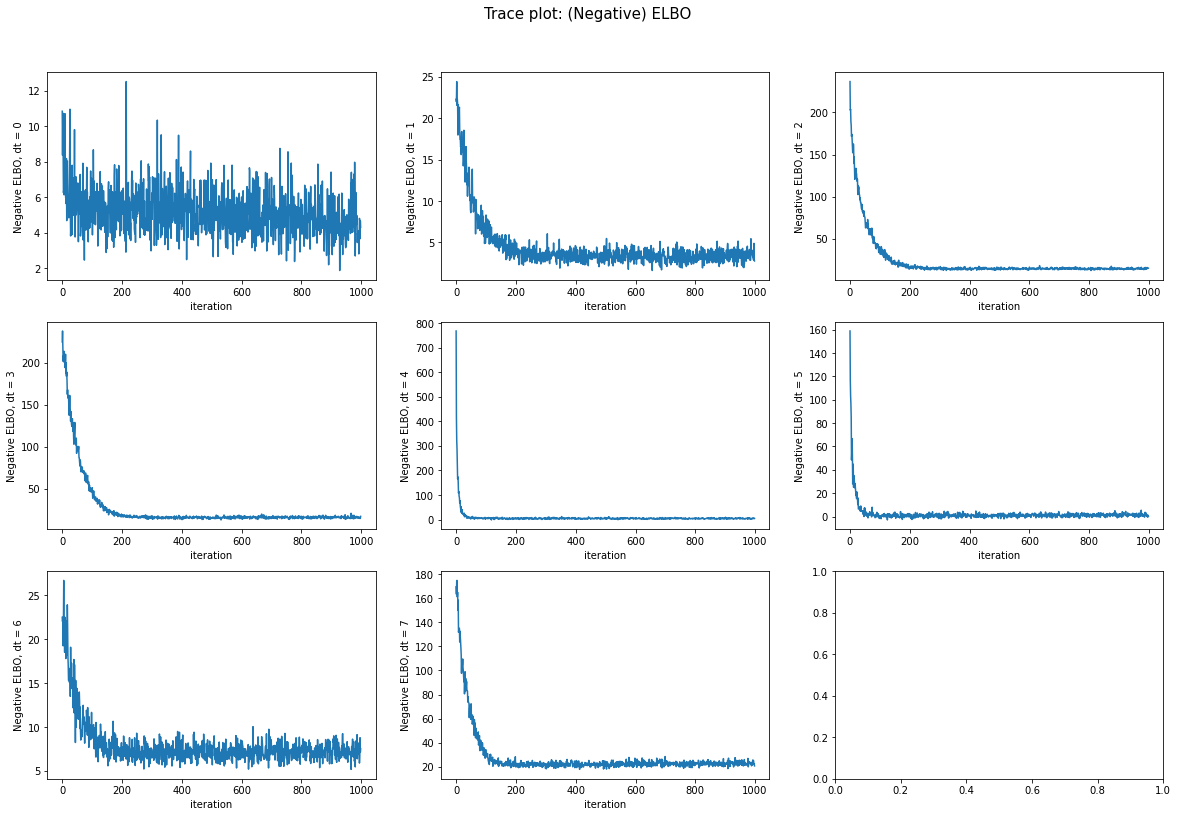

In [129]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

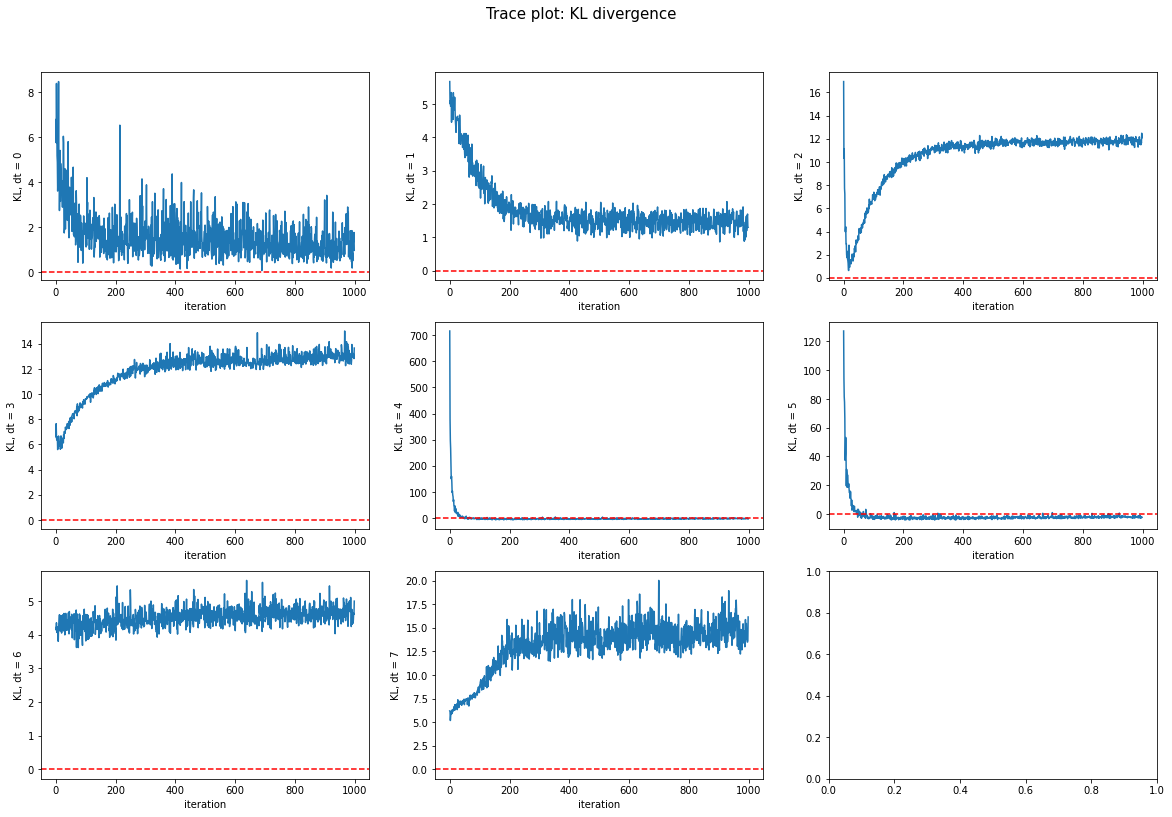

In [130]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

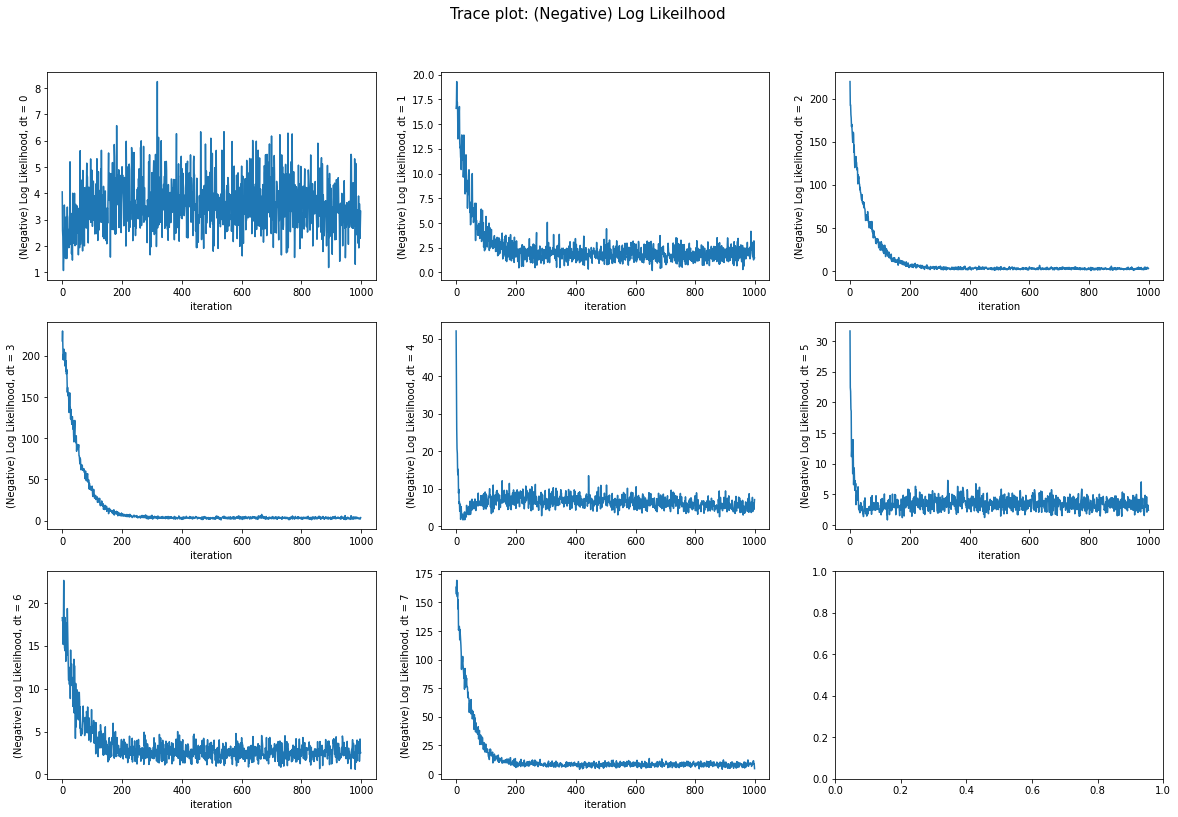

In [131]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

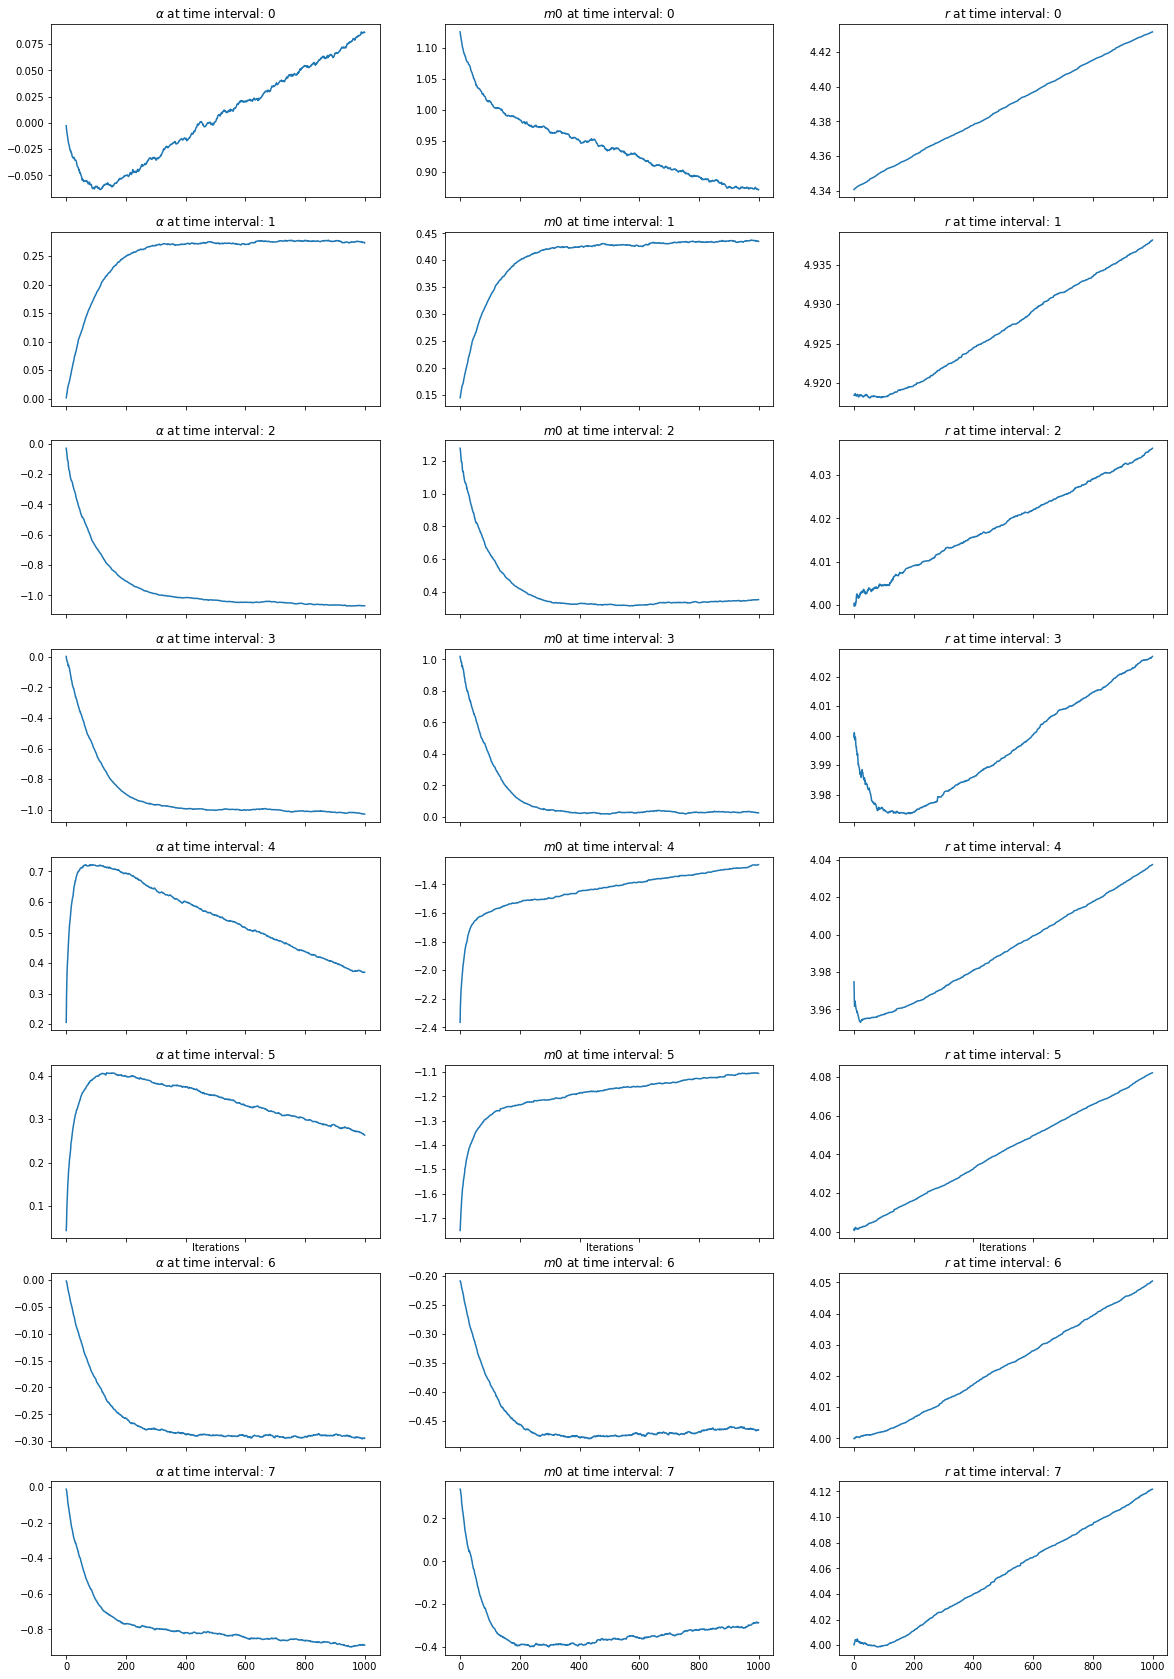

In [132]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

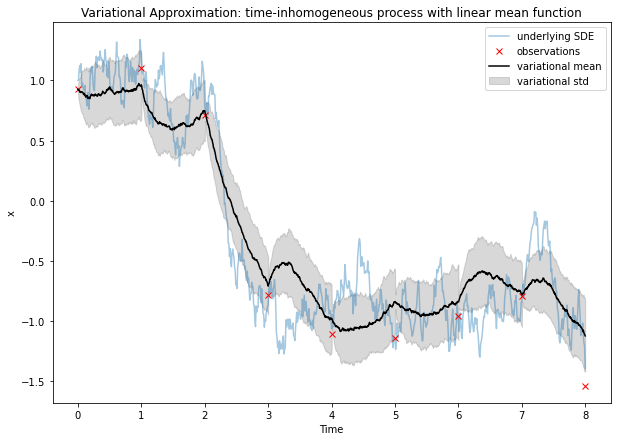

In [133]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [112]:
import pickle

In [114]:
with open('EX03_DW-SDE', 'wb') as f:
    pickle.dump(true_sde_pts, f)
    pickle.dump(true_sde_trj, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)